# Rover Project Test Notebook

This notebook contains the functions to run `perception.py` and demonstrates the product that will be displayed in the simulator.

**The code below will highlight the markdown cells:**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

**Importing relevant modules:**

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

## Quick Look at the Data

The following are example of the image data provided from Udacity and from personal recording in the simulator.

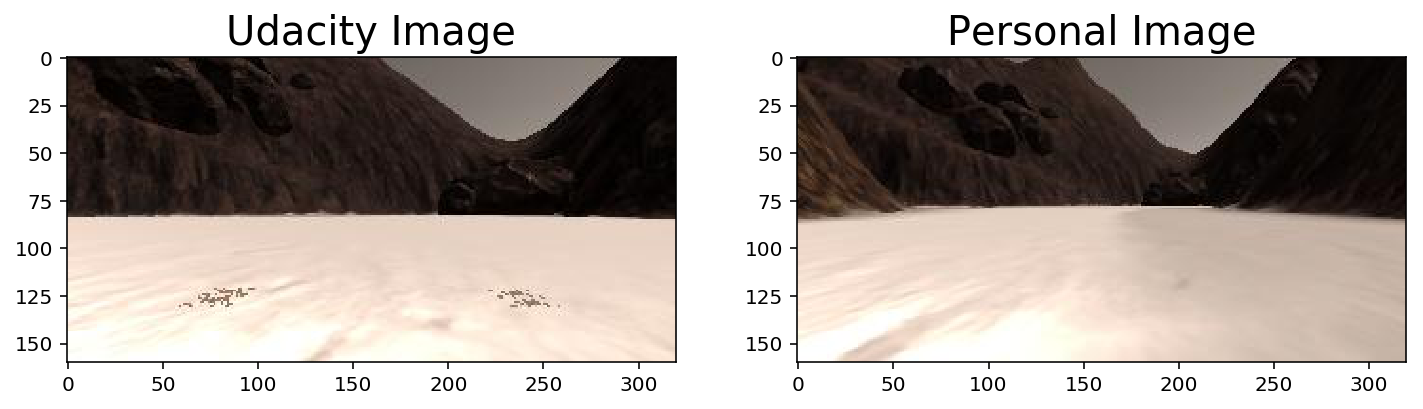

In [3]:
udacity_path = '../test-dataset/udacity-provided/IMG/*'
personal_path = '../test-dataset/IMG/*'

udacity_img_list = glob.glob(udacity_path)
personal_img_list = glob.glob(personal_path)

# Grab random images and display them
udacity_idx = np.random.randint(0, len(udacity_img_list)-1)
udacity_img = mpimg.imread(udacity_img_list[udacity_idx])

personal_idx = np.random.randint(0, len(personal_img_list)-1)
personal_img = mpimg.imread(personal_img_list[personal_idx])

fig = plt.figure(figsize=(12,3)) # Create a figure for plotting
plt.subplot(121)
plt.imshow(udacity_img)
plt.title('Udacity Image', fontsize=20)
plt.subplot(122)
plt.imshow(personal_img)
plt.title('Personal Image', fontsize=20)
plt.show()

## Color Thresholding

The followings are functions to identify navigable terrain, obstacles, and sample rocks.

In [4]:
# Identify pixel above threshold
# Threshold of RGB > 160 does a good work to identify navigable terrain
def navigable_threshold(img, rgb_thresh=(160,160,160)):
    # Create an array of zeros with the same size as the image
    # but just a single channel
    navigable = np.zeros_like(img[:,:,0])
    
    # Create a boolean array with value of "True" when threshold is met
    above_threshold = (img[:,:,0] > rgb_thresh[0]) \
                    & (img[:,:,1] > rgb_thresh[1]) \
                    & (img[:,:,2] > rgb_thresh[2]) \
            
    # Index the array of zero with the boolean array and set to 1
    navigable[above_threshold] = 1
    # Return the single-channel binary image
    return navigable

# Invert binary navigable terrain into obstacles binary image
def to_obstacle(img):
    # Create an array of zeros with the same size as the image
    obstacle = np.zeros_like(img)
    
    # Create a boolean array with value of "True" when pixel is not navigable
    is_obstacle = img == 0
            
    # Index the array of zero with the boolean array and set to 1
    obstacle[is_obstacle] = 1
    # Return the single-channel binary image
    return obstacle

# Identify pixel of sample rock
# Threshold of (100,100,0) <= RGB <= (255,255,80) does a good identifying the rocks
def sample_rock_threshold(img, low_thresh=(170, 120, 0), high_thresh=(230, 180, 60)):
    # Create an array of zeros same xy size as img, but single channel
    rock = np.zeros_like(img[:,:,0])
    
    # Create a boolean array with value of "True" when threshold is met
    within_threshold = ((img[:,:,0] >= low_thresh[0]) & (img[:,:,0] <= high_thresh[0] )) \
                    & ((img[:,:,1] >= low_thresh[1]) & (img[:,:,1] <= high_thresh[1] )) \
                    & ((img[:,:,2] >= low_thresh[2]) & (img[:,:,2] <= high_thresh[2] ))
            
    # Index the array of zeros with the boolean array and set to 1
    rock[within_threshold] = 1
    # Return the binary image
    return rock

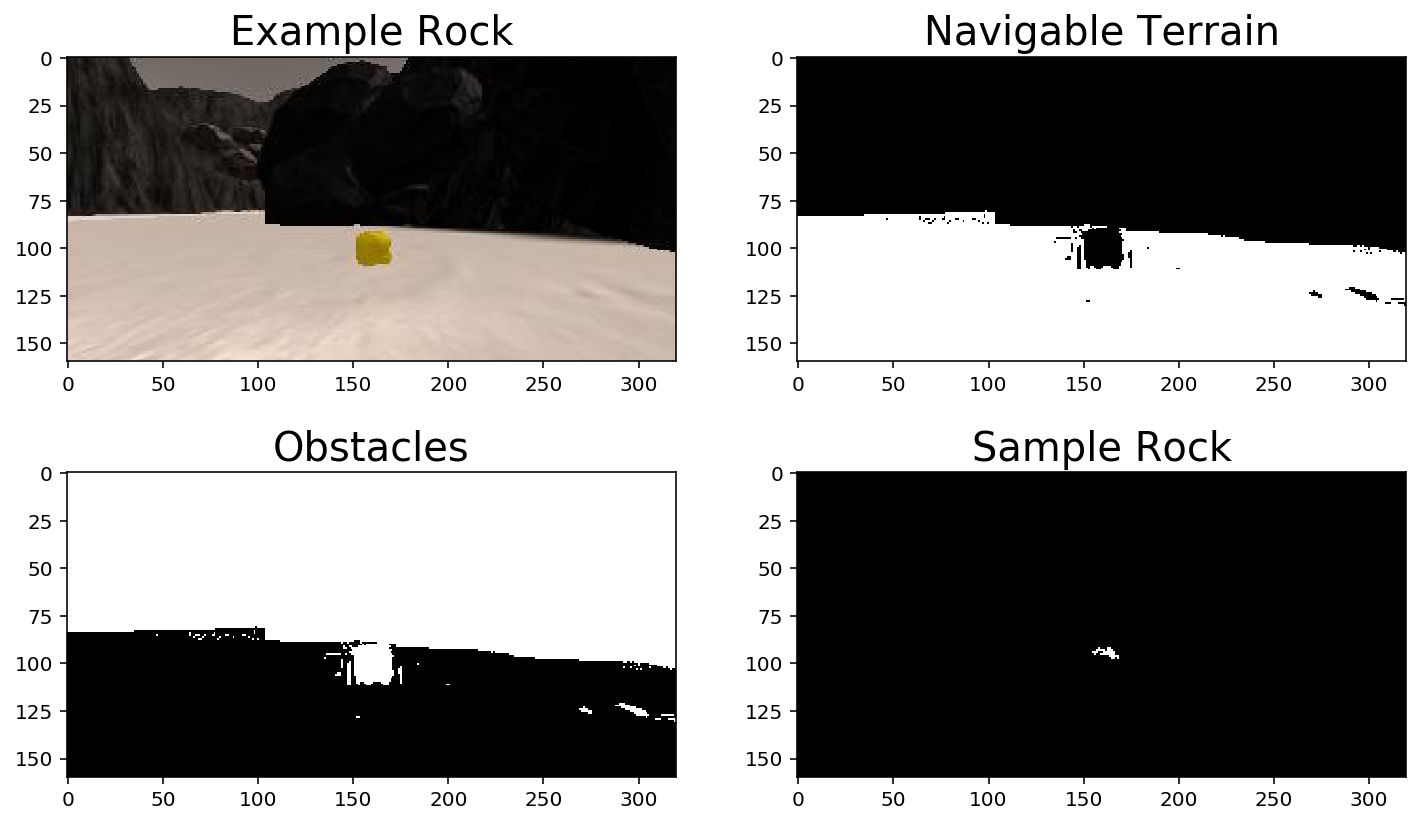

In [5]:
# Image of example sample rock
example_rock_path = '../images/calibration_images/example_rock1.jpg'
example_rock = mpimg.imread(example_rock_path)

example_navigable = navigable_threshold(example_rock)
example_obstacle = to_obstacle(example_navigable)
example_rock_threshold = sample_rock_threshold(example_rock)


# Showing the products of color thresholding for navigable terrain, obstacles, and sample rocks
fig = plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
plt.imshow(example_rock)
plt.title('Example Rock', fontsize=20)
plt.subplot(2,2,2)
plt.imshow(example_navigable, cmap='gray')
plt.title('Navigable Terrain', fontsize=20)
plt.subplot(2,2,3)
plt.imshow(example_obstacle, cmap='gray')
plt.title('Obstacles', fontsize=20)
plt.subplot(2,2,4)
plt.imshow(example_rock_threshold, cmap='gray')
plt.title('Sample Rock', fontsize=20)
plt.show()

## Calibration Data
Read in and display example grid calibration image for perspective transform.

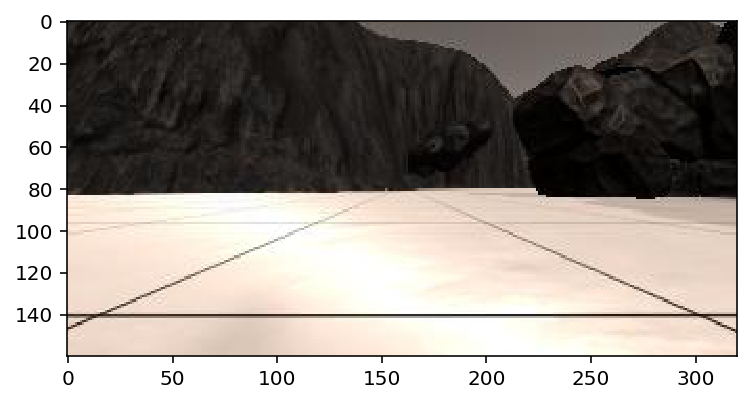

In [6]:
# Uncomment the code below to display interactive interface to obtain
# pixel position and RGB information
#%matplotlib notebook

example_grid_path = '../images/calibration_images/example_grid1.jpg'
example_grid = mpimg.imread(example_grid_path)

plt.imshow(example_grid)
plt.show()

## Perspective Transform
Define the perspective transform function with its pixel and destination source.

In [7]:
# Define a function to perform perspective transform
def perspect_transform(img, src, dst):
    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[personal_img.shape[1]/2 - dst_size, personal_img.shape[0] - bottom_offset], 
                         [personal_img.shape[1]/2 + dst_size, personal_img.shape[0] - bottom_offset], 
                         [personal_img.shape[1]/2 + dst_size, personal_img.shape[0] - 2*dst_size - bottom_offset], 
                         [personal_img.shape[1]/2 - dst_size, personal_img.shape[0] - 2*dst_size - bottom_offset]])

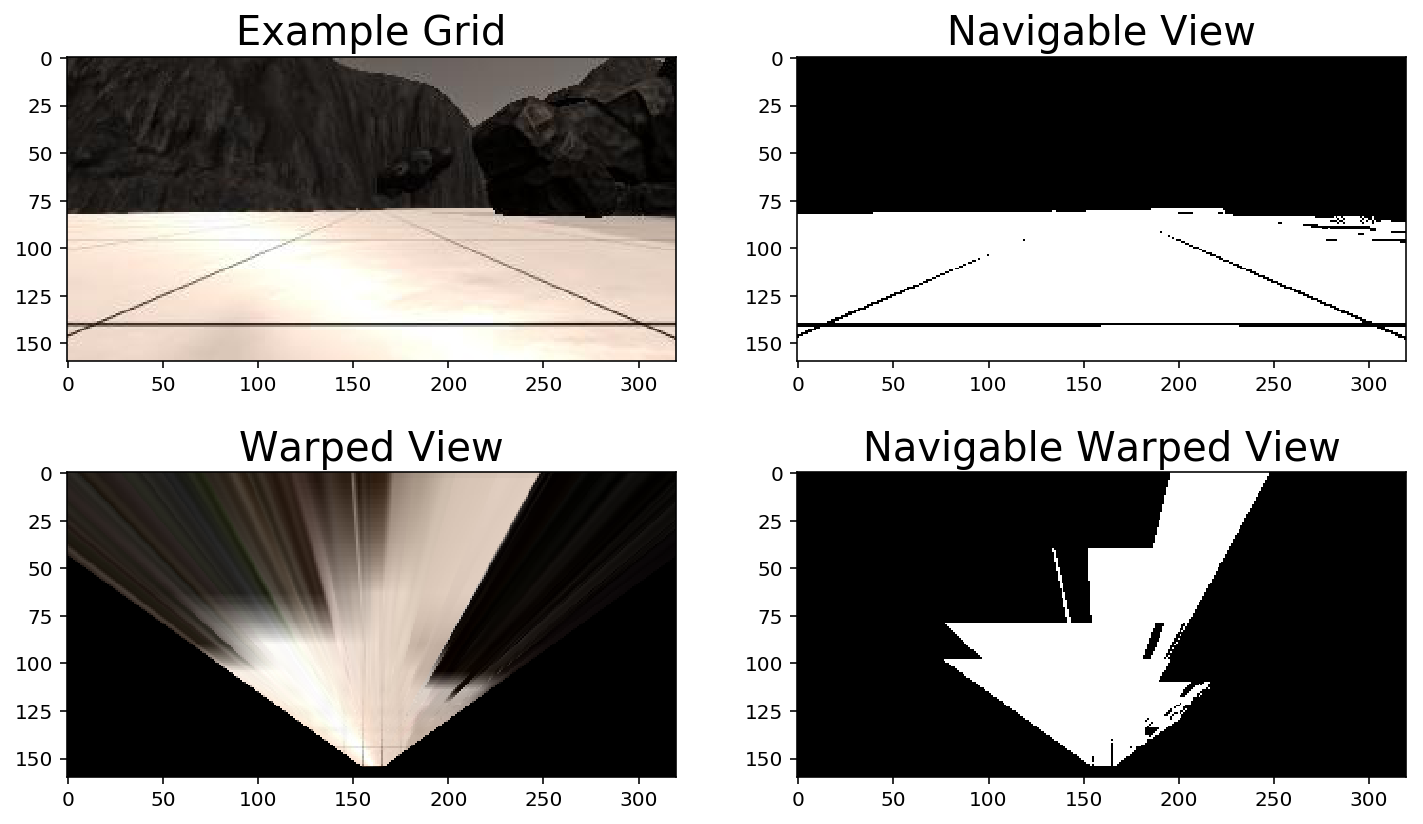

In [8]:
navigable_example_grid = navigable_threshold(example_grid)
warped_example_grid = perspect_transform(example_grid, source, destination)
warped_navigable_example_grid = perspect_transform(navigable_example_grid, source, destination)

fig = plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
plt.imshow(example_grid)
plt.title('Example Grid', fontsize=20)
plt.subplot(2,2,2)
plt.imshow(navigable_example_grid, cmap='gray')
plt.title('Navigable View', fontsize=20)
plt.subplot(2,2,3)
plt.imshow(warped_example_grid)
plt.title('Warped View', fontsize=20)
plt.subplot(2,2,4)
plt.imshow(warped_navigable_example_grid, cmap='gray')
plt.title('Navigable Warped View', fontsize=20)
plt.show()

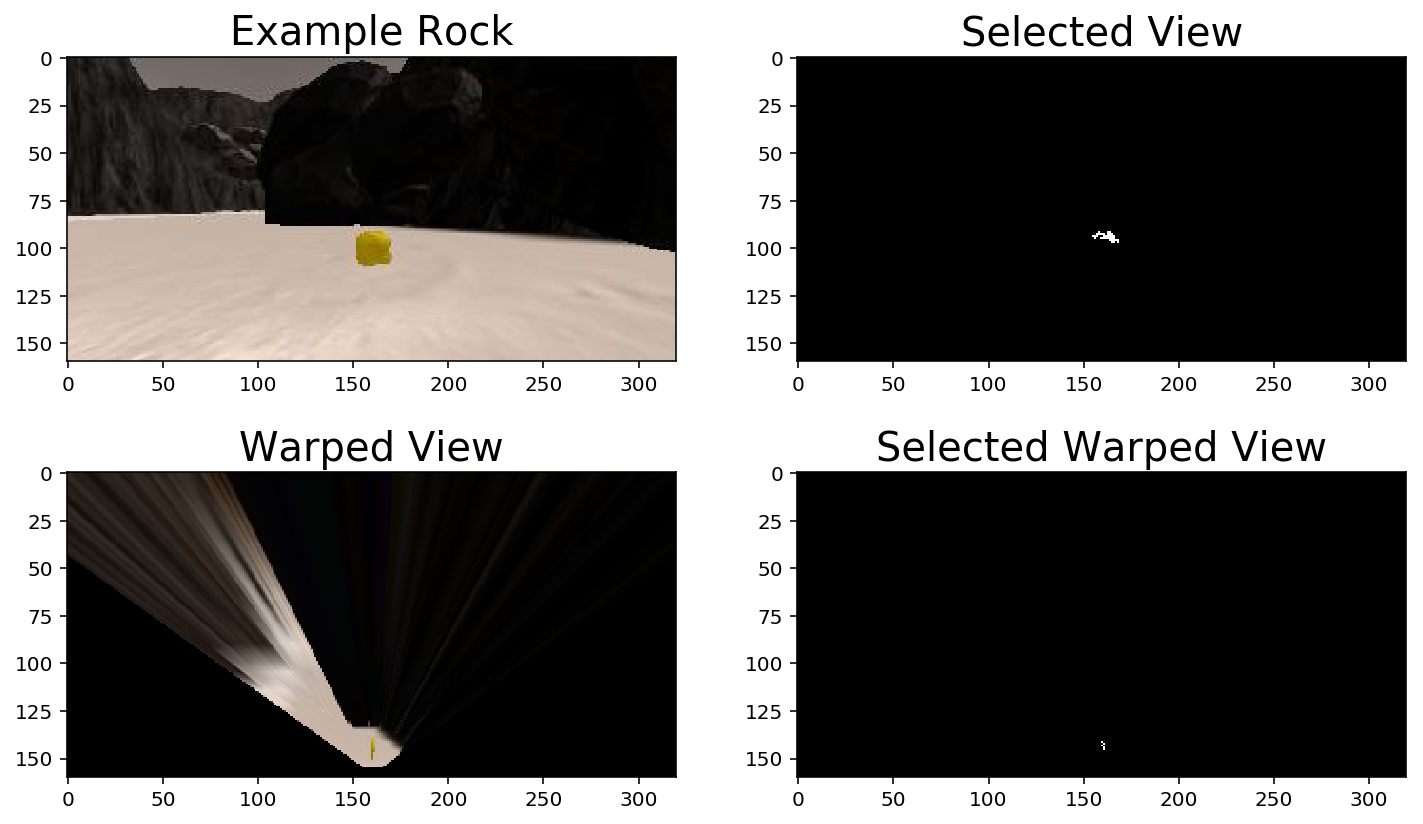

In [9]:
warped_rock = perspect_transform(example_rock, source, destination)
warped_selected_rock = perspect_transform(example_rock_threshold, source, destination)

fig = plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
plt.imshow(example_rock)
plt.title('Example Rock', fontsize=20)
plt.subplot(2,2,2)
plt.imshow(example_rock_threshold, cmap='gray')
plt.title('Selected View', fontsize=20)
plt.subplot(2,2,3)
plt.imshow(warped_rock)
plt.title('Warped View', fontsize=20)
plt.subplot(2,2,4)
plt.imshow(warped_selected_rock, cmap='gray')
plt.title('Selected Warped View', fontsize=20)
plt.show()

## Coordinate Transformation
Define functions used to do coordinate transforms and apply them to an image.

In [10]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Calculate pixel positions with reference to the rover 
    # position being at the center bottom of the image.  
    y_pos, x_pos = binary_img.nonzero()

    x_pixel = -(y_pos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(x_pos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert from cartesian to polar coordinates
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi/180
    # Apply a rotation
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


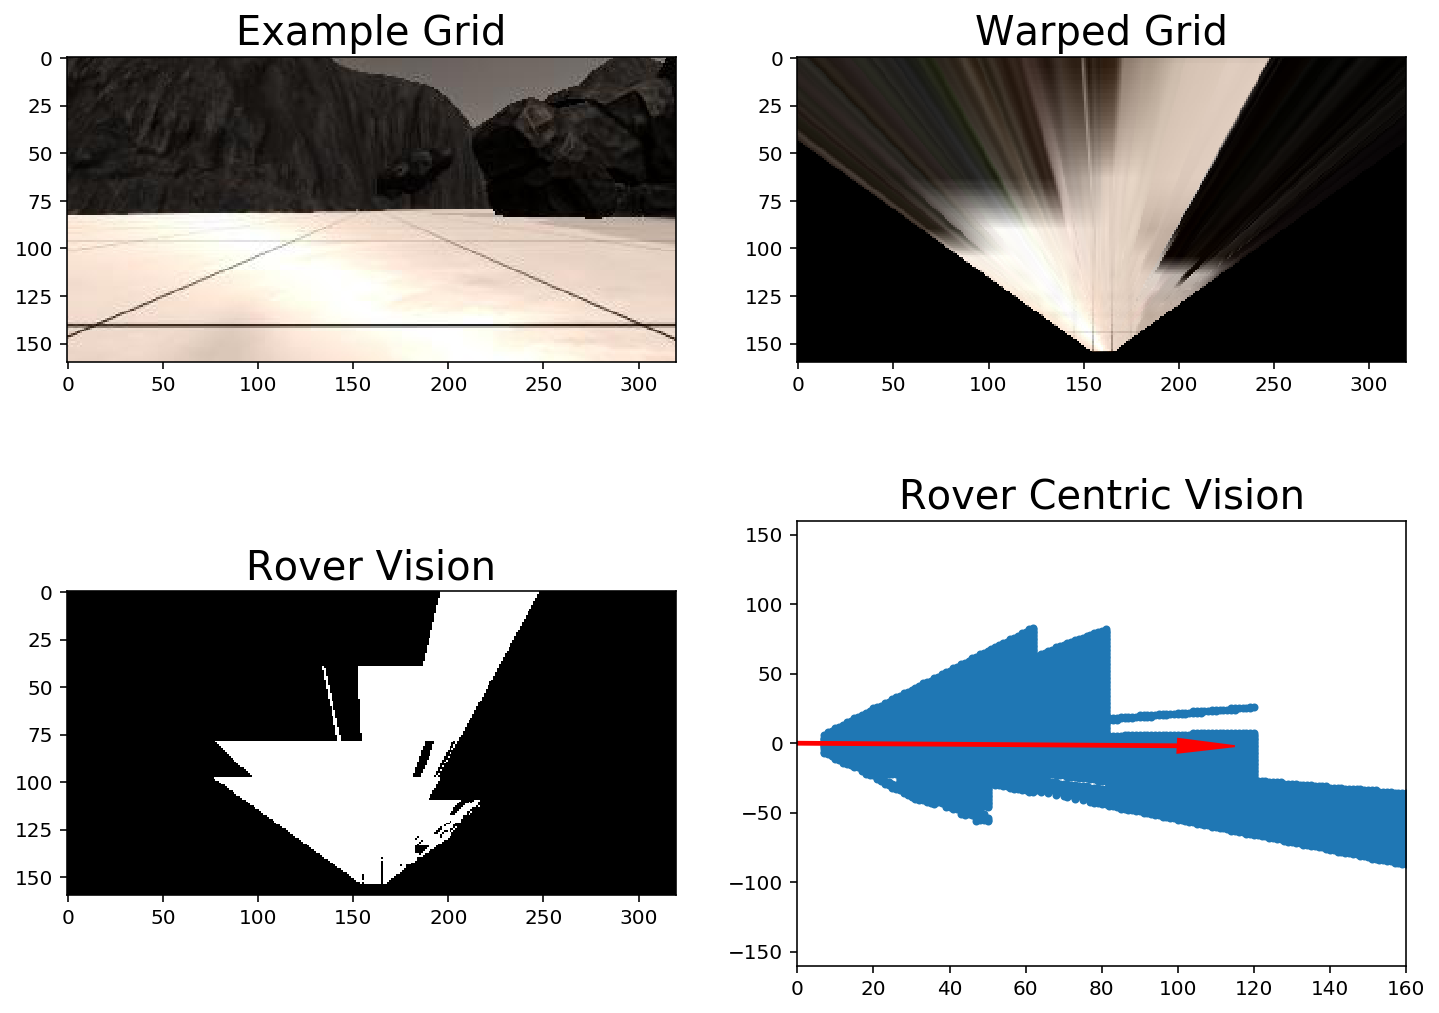

In [11]:
# Calculate rover centric-centric coordinates and distance/angle to all pixels
xpix, ypix = rover_coords(warped_navigable_example_grid)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.imshow(example_grid)
plt.title('Example Grid', fontsize=20)
plt.subplot(2,2,2)
plt.imshow(warped_example_grid)
plt.title('Warped Grid', fontsize=20)
plt.subplot(2,2,3)
plt.imshow(warped_navigable_example_grid, cmap='gray')
plt.title('Rover Vision', fontsize=20)
plt.subplot(2,2,4)
plt.plot(xpix, ypix, '.')
plt.title('Rover Centric Vision', fontsize=20)
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()

## Read in saved data and ground truth map of the world
Storing the saved record from the simulator into a `pandas` dataframe. The "ground truth" map of the world depicts all navigable terrain in the simulator's world.

In [12]:
import pandas as pd

# Read in CSV file as a dataframe
df = pd.read_csv('../test-dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames

# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../images/calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

## Processing recorded images
The following is a function that will process the images recorded by the rover from the simulator to return an image of a mosaic of the analysis process.

In [13]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # 1) Create a blank image to be returned as a mosaic image
        # Height = 2 times [height of worldmap image]
        # Width = 2 times [width of image]
    output_image = np.zeros((data.worldmap.shape[0]*2, img.shape[1]*2, 3))
        # Placing the original image at the top left of the mosaic image
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    
    # 2) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable = navigable_threshold(img)
    obstacle = to_obstacle(navigable)
    rock = sample_rock_threshold(img)
    
    # 3) Apply perspective transform
    navigable_warped = perspect_transform(navigable, source, destination)
    obstacle_warped = perspect_transform(obstacle, source, destination)
    rock_warped = perspect_transform(rock, source, destination)
    
    # 4) Create three channels image to portray the rover vision of navigable 
    # terrain/obstacles/rock samples and placing the rover vision at the top
    # right of the mosaic image
    vision_image = np.zeros((160, 320, 3), dtype=np.float)
    vision_image[:,:,0] = obstacle_warped*255
    vision_image[:,:,1] = rock_warped*255
    vision_image[:,:,2] = navigable_warped*255
    
    output_image[0:160,320:640] = vision_image

    # 5) Convert rover-centric coordinates to world coordinates
        # Obtain rover-centric pixel coordinates of navigable terrain/obstacles/rock samples
    navigable_xpix, navigable_ypix = rover_coords(navigable_warped)
    obstacle_xpix, obstacle_ypix = rover_coords(obstacle_warped)
    rock_xpix, rock_ypix = rover_coords(rock_warped)
        # Obtain world coordinates of navigable terrain/obstacles/rock samples
    navigable_x_world, navigable_y_world =  pix_to_world(navigable_xpix, navigable_ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)
    obstacle_x_world, obstacle_y_world =  pix_to_world(obstacle_xpix, obstacle_ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)
    rock_x_world, rock_y_world =  pix_to_world(rock_xpix, rock_ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)

    
    # 6) Update worldmap and placing the image at the bottom right of the mosaic image
        # Setting the worldmap coordinates for rocks to be the one closest to the rover
    if rock_warped.any():
        rock_dist, rock_ang = to_polar_coords(rock_xpix, rock_ypix)
        rock_idx = np.argmin(rock_dist)
        rock_x_closest = rock_x_world[rock_idx]
        rock_y_closest = rock_y_world[rock_idx]
        data.worldmap[rock_y_closest, rock_x_closest, 1] = 255

    data.worldmap[obstacle_y_world, obstacle_x_world, 0] = 255
    data.worldmap[navigable_y_world, navigable_x_world, 2] = 255
    
        # Overlay worldmap with ground truth map
    if data.count == 0:
        data.map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    else:
        data.map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        
    output_image[img.shape[0]+20:img.shape[0]+20+200, 220:420] = np.flipud(data.map_add)
    
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
The cell below creates a video from the processed image data.

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 627/627 [00:12<00:00, 66.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 9.14 s, sys: 1.8 s, total: 10.9 s
Wall time: 12.4 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [15]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [16]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))